# 1.分析目的：
完成用户分类（RFM 模型），即对比分析不同用户群体在时间、地区等维度下交易量，交易金额指标，并根据分析结果提出优化建议。

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import Pie
import pyecharts.options as opts


In [63]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 2.读取数据

In [64]:
df = pd.read_csv("data.csv",encoding='utf-8')

In [65]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 3.数据维度

In [66]:
df.shape

(541909, 8)

# 4.数据信息

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 5.数据清洗

## 5.1缺失处理

In [68]:
# 统计缺失率
df.apply(lambda x: sum(x.isnull()) / len(x), axis=0)

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [69]:
# Description字段对该数据分析目标无意义，删除
df.drop(['Description'], axis=1, inplace=True)

In [70]:
# 缺失的用户ID填充为'U'
df['CustomerID'] = df['CustomerID'].fillna('U')

In [71]:
# 每个订单的发生额
df['amount'] = df['Quantity'] * df['UnitPrice']

In [72]:
# 将 InvoiceDate字段拆分成两列，之后删除InvoiceDate字段
df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['Time'] = pd.to_datetime(df['InvoiceDate']).dt.time
df['Date'] = pd.to_datetime(df['Date'])
df.drop(['InvoiceDate'], axis=1, inplace=True)

In [73]:
df.head()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,amount,Date,Time
0,536365,85123A,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,8,2.75,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


# 6.重复值

In [74]:
df.describe()

,Quantity,UnitPrice,amount
count,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,17.987795
std,218.081158,96.759853,378.810824
min,-80995.000000,-11062.060000,-168469.600000
25%,1.000000,1.250000,3.400000
50%,3.000000,2.080000,9.750000
75%,10.000000,4.130000,17.400000
max,80995.000000,38970.000000,168469.600000


In [76]:
# 删除重复值
df = df.drop_duplicates()

# 7.异常分析

## 7.1缺失处理

In [77]:
# 对单价进行异常分析
df2 = df.loc[df['UnitPrice'] <= 0]

In [78]:
df2.shape[0]/df.shape[0]

0.0046809866595607106

In [79]:
# 异常值中单价的分类
df2['UnitPrice'].value_counts()

 0.00        2510
-11062.06       2
Name: UnitPrice, dtype: int64

# 8.数据分析与可视化

## 8.1退货率

In [80]:
df1 = df.loc[df['Quantity'] <= 0]

In [81]:
# 退货情况
returns = pd.pivot_table(df1, index=df1['Date'].dt.year, columns=df1['Date'].dt.month, values='amount', aggfunc={'amount':np.sum})
returns

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74729.12
2011,-131363.05,-25519.15,-34201.28,-44600.65,-47202.51,-70569.78,-37919.13,-54330.8,-38838.51,-81895.5,-47720.98,-205089.27


In [82]:
# 筛选出销售的正常数据
df3 = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [83]:
# 营业额
sales = pd.pivot_table(df3, index=df3['Date'].dt.year, columns=df3['Date'].dt.month, values='amount', aggfunc={'amount':np.sum})
sales

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,821452.73
2011,689811.61,522545.56,716215.26,536968.491,769281.76,760547.01,718076.121,757841.38,1056435.192,1151263.73,1503329.78,637790.33


## 8.1.1 2011年每月退货率

In [85]:
# 退货率
return_rate = np.abs(returns) / sales
return_rate

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090972
2011,0.190433,0.048836,0.047753,0.08306,0.061359,0.092788,0.052807,0.071692,0.036764,0.071135,0.031744,0.321562


## 8.1.2 2011年月平均退货率

In [86]:
# 平均退货率
avg_return = return_rate[1:2].mean(axis=1).values[0]
avg_return

0.09249438130255831

## 8.1.3 可视化

In [87]:
# 取出2011年退货率数据，用于画图
return_rate_11 = [round(i, 2) for i in return_rate.values.tolist()[1]]
month = return_rate.columns.tolist()

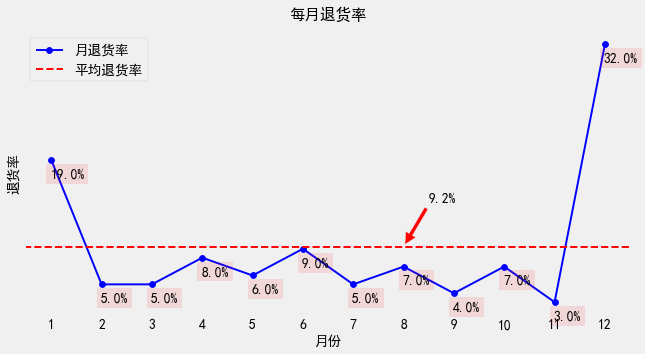

In [126]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(10,5), dpi=70)
plt.style.use('fivethirtyeight')
plt.plot(month, return_rate_11, 'bo-', lw=2, label='月退货率')
plt.title('每月退货率', fontdict={'color':'black', 'fontsize':16}, pad=12)
plt.xlabel('月份', fontdict={'color':'black', 'fontsize':14})
plt.ylabel('退货率', fontdict={'color':'black', 'fontsize':14})
plt.yticks([])
plt.xticks(np.arange(1, 13))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, position: '{:.1f}%'.format(x*100)))
for i, j in zip(month, return_rate_11):
    plt.text(i-0.02, j-0.02, '{:.1f}%'.format(j*100), bbox=dict(facecolor='red', alpha=0.1))
plt.axhline(y=avg_return,ls='--', color='r', lw=2, label='平均退货率') 
plt.annotate('{:.1f}%'.format(round(avg_return, 3)*100), xy=(8, avg_return), xytext=(8.5, avg_return+0.05), arrowprops=dict(facecolor='red', shrink=0.05))
plt.grid(b=False)
plt.legend(loc='best')
plt.show()

# 8.2 用户分级（RFM模型）

## 8.2.1 计算R,F,M

In [89]:
# 每位用户最近一次购买时间
customer_newest_consume = df3.groupby('CustomerID')['Date'].max()
customer_newest_consume.head()

CustomerID
12346.0   2011-01-18
12347.0   2011-12-07
12348.0   2011-09-25
12349.0   2011-11-21
12350.0   2011-02-02
Name: Date, dtype: datetime64[ns]

In [90]:
# 目标时间（最近一次购买时间）
newest_time_consume = df3['Date'].max()

In [91]:
# 每位用户最近购买时间于目标时间的距离
value_R = (newest_time_consume - customer_newest_consume).dt.days
value_R

CustomerID
12346.0    325
12347.0      2
12348.0     75
12349.0     18
12350.0    310
          ... 
18281.0    180
18282.0      7
18283.0      3
18287.0     42
U            0
Name: Date, Length: 4339, dtype: int64

In [92]:
# nunique()去重
value_F = df3.groupby('CustomerID')['InvoiceNo'].nunique()
value_F

CustomerID
12346.0       1
12347.0       7
12348.0       4
12349.0       1
12350.0       1
           ... 
18281.0       1
18282.0       2
18283.0      16
18287.0       3
U          1428
Name: InvoiceNo, Length: 4339, dtype: int64

In [93]:
value_M = df3.groupby('CustomerID')['amount'].sum()
value_M

CustomerID
12346.0    7.718360e+04
12347.0    4.310000e+03
12348.0    1.797240e+03
12349.0    1.757550e+03
12350.0    3.344000e+02
               ...     
18281.0    8.082000e+01
18282.0    1.780500e+02
18283.0    2.045530e+03
18287.0    1.837280e+03
U          1.754902e+06
Name: amount, Length: 4339, dtype: float64

## 8.2.2 观察R,F,M的数据分布

In [94]:
value_R.describe()

count    4339.000000
mean       92.038258
std       100.010502
min         0.000000
25%        17.000000
50%        50.000000
75%       141.500000
max       373.000000
Name: Date, dtype: float64

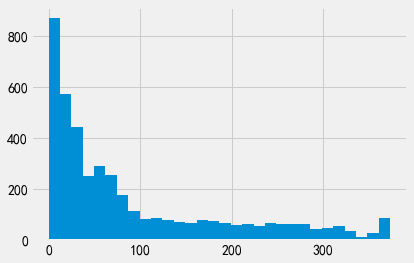

In [95]:
plt.hist(value_R, bins=30)
plt.show()

In [96]:
value_M.describe()

count    4.339000e+03
mean     2.452537e+03
std      2.808589e+04
min      3.750000e+00
25%      3.065050e+02
50%      6.685800e+02
75%      1.660890e+03
max      1.754902e+06
Name: amount, dtype: float64

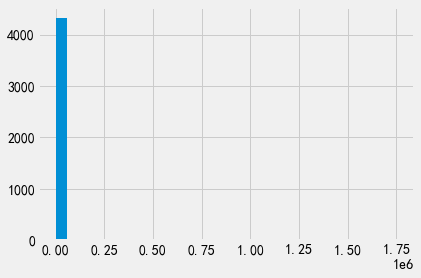

In [97]:
# 异常值严重影响了数据的分布
plt.hist(value_M, bins=30)
plt.show()

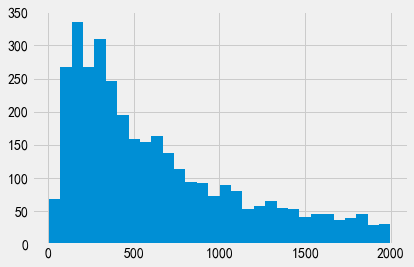

In [98]:
# 绘制金额小于2000的
plt.hist(value_M[value_M < 2000], bins=30)
plt.show()

In [99]:
# 中位数是2，而最大值是1428，异常值很严重
value_F.describe()

count    4339.000000
mean        4.600138
std        22.943499
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1428.000000
Name: InvoiceNo, dtype: float64

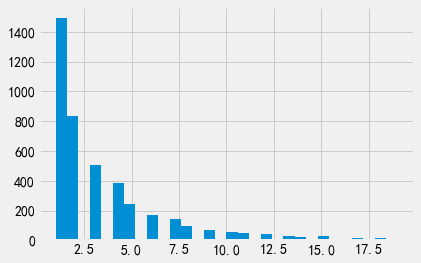

In [100]:
plt.hist(value_F[value_F < 20], bins=30)
plt.show()

## 8.2.3 对R,F,M分段（给予权重）

In [101]:
# 可根据分位数来分段
print(' value_R:\t', value_R.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist())
print(' value_F:\t', value_F.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist())
print(' value_M:\t', [round(i) for i in value_M.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()])

 value_R:	 [0.0, 5.0, 12.0, 22.0, 32.0, 50.0, 71.0, 108.0, 179.0, 262.2000000000003, 373.0]
 value_F:	 [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 6.0, 9.0, 1428.0]
 value_M:	 [4, 155, 250, 350, 488, 669, 934, 1348, 2056, 3641, 1754902]


In [102]:
# 构建分段指标
bins_R = [0, 30, 90, 180, 360, 720]
bins_F = [1, 2, 5, 10, 20, 5000]
bins_M = [0, 500, 2000, 5000, 10000, 200000]

In [104]:
# 分段，label可以理解为权重，对R而言，值越小表示里目标时间近，所占权重也就更大，F,M同理
score_R = pd.cut(value_R, bins_R, labels=[5,4,3,2,1], right=False)
score_F = pd.cut(value_F, bins_F, labels=[1,2,3,4,5], right=False)
score_M = pd.cut(value_M, bins_M, labels=[1,2,3,4,5], right=False)

In [105]:
score_R

CustomerID
12346.0    2
12347.0    5
12348.0    4
12349.0    5
12350.0    2
          ..
18281.0    2
18282.0    5
18283.0    5
18287.0    4
U          5
Name: Date, Length: 4339, dtype: category
Categories (5, int64): [5 < 4 < 3 < 2 < 1]

In [106]:
# 横向合并，axis=1；纵向合并，axis=0(默认)
rfm = pd.concat([score_R, score_F, score_M], axis=1)

In [107]:
rfm.rename(columns={'Date':'R_value', 'InvoiceNo':'F_value', 'amount':'M_value'}, inplace=True)

In [108]:
# （U,M_value)为NaN原因是在对M分段指标构建时，最大值到20万，而U累计超过175万
rfm

,R_value,F_value,M_value
CustomerID,,,
12346.0,2,1,5
12347.0,5,3,3
12348.0,4,2,2
12349.0,5,1,2
12350.0,2,1,1
...,...,...,...
18281.0,2,1,1
18282.0,5,2,1
18283.0,5,4,3


In [109]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346.0 to U
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   R_value  4339 non-null   category
 1   F_value  4339 non-null   category
 2   M_value  4336 non-null   category
dtypes: category(3)
memory usage: 176.3+ KB


In [110]:
# 转换类型用于计算
for i in ['R_value', 'F_value', 'M_value']:
    rfm[i] = rfm[i].astype(float)

In [111]:
rfm.describe()

,R_value,F_value,M_value
count,4339.000000,4339.000000,4336.000000
mean,3.821618,2.028117,1.885609
std,1.174880,0.997989,0.951810
min,1.000000,1.000000,1.000000
25%,3.000000,1.000000,1.000000
50%,4.000000,2.000000,2.000000
75%,5.000000,3.000000,2.000000
max,5.000000,5.000000,5.000000


## 8.2.4 分级标准

In [113]:
# 根据平均值构建分级
rfm['R'] = np.where(rfm['R_value'] > 3.82, '高', '低')
rfm['F'] = np.where(rfm['F_value'] > 2.03, '高', '低')
rfm['M'] = np.where(rfm['M_value'] > 1.89, '高', '低')

In [114]:
rfm

,R_value,F_value,M_value,R,F,M
CustomerID,,,,,,
12346.0,2.0,1.0,5.0,低,低,高
12347.0,5.0,3.0,3.0,高,高,高
12348.0,4.0,2.0,2.0,高,低,高
12349.0,5.0,1.0,2.0,高,低,高
12350.0,2.0,1.0,1.0,低,低,低
...,...,...,...,...,...,...
18281.0,2.0,1.0,1.0,低,低,低
18282.0,5.0,2.0,1.0,高,低,低
18283.0,5.0,4.0,3.0,高,高,高


In [115]:
# 汇总
rfm['value'] = rfm['R'].str[:] + rfm['F'].str[:] + rfm['M'].str[:]

In [116]:
rfm

,R_value,F_value,M_value,R,F,M,value
CustomerID,,,,,,,
12346.0,2.0,1.0,5.0,低,低,高,低低高
12347.0,5.0,3.0,3.0,高,高,高,高高高
12348.0,4.0,2.0,2.0,高,低,高,高低高
12349.0,5.0,1.0,2.0,高,低,高,高低高
12350.0,2.0,1.0,1.0,低,低,低,低低低
...,...,...,...,...,...,...,...
18281.0,2.0,1.0,1.0,低,低,低,低低低
18282.0,5.0,2.0,1.0,高,低,低,高低低
18283.0,5.0,4.0,3.0,高,高,高,高高高


## 8.2.5 确认分级

In [117]:
# 去除空格处理
rfm['value'] = rfm['value'].str.strip()

In [118]:
# 构建用户分级函数
def trans_value(x):
    if x == '高高高': return '重要价值客户'
    elif x == '高低高': return '重要发展客户'
    elif x == '高高低': return '一般价值客户'
    elif x == '低高高': return '重要保持客户'
    elif x == '低低高': return '重要挽留客户'
    elif x == '高低低': return '一般发展客户'
    elif x == '低高低': return '一般保持客户'
    else: return '一般挽留客户'

In [119]:
rfm['用户等级'] = rfm['value'].apply(trans_value)

In [120]:
rfm

,R_value,F_value,M_value,R,F,M,value,用户等级
CustomerID,,,,,,,,
12346.0,2.0,1.0,5.0,低,低,高,低低高,重要挽留客户
12347.0,5.0,3.0,3.0,高,高,高,高高高,重要价值客户
12348.0,4.0,2.0,2.0,高,低,高,高低高,重要发展客户
12349.0,5.0,1.0,2.0,高,低,高,高低高,重要发展客户
12350.0,2.0,1.0,1.0,低,低,低,低低低,一般挽留客户
...,...,...,...,...,...,...,...,...
18281.0,2.0,1.0,1.0,低,低,低,低低低,一般挽留客户
18282.0,5.0,2.0,1.0,高,低,低,高低低,一般发展客户
18283.0,5.0,4.0,3.0,高,高,高,高高高,重要价值客户


## 8.2.6 用户分级结果及可视化

In [121]:
re = rfm['用户等级'].value_counts()
re

重要价值客户    1034
重要发展客户    1017
一般挽留客户     923
一般发展客户     829
重要挽留客户     455
重要保持客户      66
一般价值客户      10
一般保持客户       5
Name: 用户等级, dtype: int64

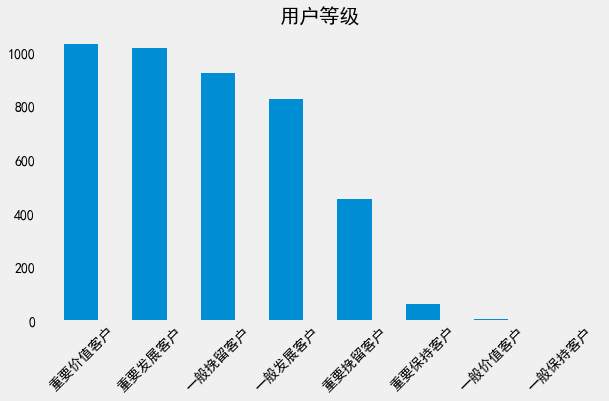

In [123]:
plt.figure(figsize=(9,5))
plt.bar(re.index.tolist(), re.values.tolist(), width=0.5)
plt.grid(b=False)
plt.xticks(rotation=45)
plt.title('用户等级')
plt.show()

In [127]:
pie = (
    Pie(init_opts=opts.InitOpts(width='900px', height='500px', bg_color='#E6E6FA'))   
    .add(
        ' ',
        data_pair = [[x,y] for x, y in zip(re.index.tolist(), re.values.tolist())],
        rosetype = 'radius',
        radius = '55%',
        center = ['50%', '50%'],
        label_opts=opts.LabelOpts(is_show=False, position='center')
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title='用户等级比例',
            pos_left='center',
            pos_top='20',
            title_textstyle_opts=opts.TextStyleOpts(color='#000'),
        ),
        legend_opts=opts.LegendOpts(is_show=False)
    )
    .set_series_opts(
        tooltip_opts=opts.TooltipOpts(trigger='item', formatter='{a} <br>{b}: {c} ({d}%)'),
        label_opts=opts.LabelOpts(color='rgba(25, 25, 112, 0.8)'),
    )
)
pie.render_notebook()

# 9.结论与建议

## 一、结论
>1月和12月退货率高于月平均退货率的原因：

>1.根据第一篇实战数据分析知道影响总销量最大的是英国，同时其他也大都是西方国家，1月1日是他们的新年

>2.以及12月25日是圣诞节，购物量大幅增加的同时也导致了退货量的增加。

## 二、建议
>1.实行积分制度，每次客户选择不同的航班，购买的商品都可以按商品的价格一定比例换算成积分，达到一定积分时可以减少扣除支付时的费用，或者兑换礼品

>2.会员升级或者保级，在会员升级或保级评价的时间点前，对接近但尚未达到要求的较高消费客户进行提醒或促销活动，提高客户满意度。

>3.获取新客成本远大于维持老客，应努力维系客户关系水平，保持优质客户。差异化管理、精准营销，提高客户忠诚度、满意度，延长客户高水平消费。